In [2]:
import ipdb
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pylab as pylab
import cartopy
from utils import constants as cnst
from eod import msg
from utils import u_grid, u_interpolate as u_int, constants as cnst, u_arrays, u_darrays, u_met
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as feature
import cartopy.io.shapereader as shapereader
import pickle as pkl
import glob

coast = shapereader.natural_earth(resolution='110m',
                                  category='physical',
                                  name='coastline')

countries = shapereader.natural_earth(resolution='110m',
                                      category='cultural',
                                      name='admin_0_countries')

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [13]:
filetag = 'pl'
era_hour = 12

In [14]:
#node_days = pkl.load(open(cnst.network_data + 'data/SOMS/saves/node3_MCS_matchTable.p', "rb"))
node_days = pd.read_csv(cnst.DATA + '/SOMS/saves/3x3_Nodes_fullYear/mcs_matchtable/node3_MCS_matchTable_mergedNodes_NO-MCS_fullYear.csv', index_col=0, parse_dates=True)

In [15]:
pd.to_datetime(node_days.index)[0].replace(hour=5)

Timestamp('2004-04-09 05:30:00')

In [16]:
node_days

,prcp,q925,q650,t925,shear,month,hour,year,day,area,tmin,rh,tcwv,lat,lon
2004-04-09 17:30:00,57.492078,14.864393,7.199410,23.502893,10.523680,4,17,2004,9,27750,-86.092362,76.939026,52.285583,5.724071,8.973695
2004-04-09 18:00:00,1.546498,14.201927,7.481948,23.805444,11.756159,4,18,2004,9,30425,-74.182555,70.826294,54.115967,5.745959,8.807680
2004-04-09 18:30:00,7.863972,15.635261,6.705916,21.926111,9.565559,4,18,2004,9,31125,-78.286962,88.278519,53.875740,5.653775,-7.859103
2004-04-09 18:30:00,7.394670,15.360639,6.578586,23.179956,12.729914,4,18,2004,9,17525,-77.938944,79.572632,48.113495,7.829097,-9.373507
2004-04-09 18:30:00,8.123865,14.202960,5.793951,26.281183,10.709904,4,18,2004,9,20025,-79.788394,61.539886,41.596397,8.344686,-7.975895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-08-07 17:00:00,2.735004,15.732979,8.232782,21.021295,4.692850,8,17,2015,7,7000,-65.702465,93.057945,56.813354,8.989730,-2.278970
2015-08-07 18:00:00,12.086042,15.479974,6.129366,20.829523,2.507865,8,18,2015,7,5775,-75.343800,92.618835,55.035545,7.445678,6.269572
2015-08-07 18:00:00,8.797677,15.386710,6.879452,25.665247,6.217617,8,18,2015,7,8100,-67.946098,68.634430,42.959145,9.069827,9.287769
2015-08-07 18:30:00,24.130327,14.926009,7.460207,22.632257,0.331555,8,18,2015,7,9700,-78.000000,79.992493,49.117531,7.911274,-9.156312


In [17]:
def save_node_clim(filetag, node, era_hour):
    
    nodestr = 'node'+str(node)
    node_days = pd.read_csv(cnst.DATA + '/SOMS/saves/3x3_Nodes_fullYear/mcs_matchtable/'+nodestr+'_MCS_matchTable_mergedNodes_NO-MCS_fullYear.csv', index_col=0, parse_dates=True)
    #node_days = pkl.load(open(cnst.network_data + 'data/SOMS/saves/3x3/MCStable_3x3_5-9N/'+nodestr+'_MCS_matchTable.p', "rb"))
    
    #### potentially reduce MCS box here
    region = (node_days.lat>5) & (node_days.lat<8) & (node_days.lon>-10) & (node_days.lon<10)
    node_days = node_days[region]
    
#     node_days_era = []
#     for nd in node_days.index:
#         node_days_era.append(nd.replace(hour=era_hour))
#     node_days_era = pd.Series(node_days_era).values

    node_days_era = []
    for nd in node_days.index:
        node_days_era.append(nd)
    node_days_era = pd.Series(node_days_era).values
        
    if filetag == 'pl':
        fft = 'pressure_levels'
    else:
        fft = 'surface'
        
    filebase = cnst.other_drive + '/ERA5_WAf/hourly/' 
    filepath = filebase + fft+'/ERA5_2*'+filetag+'.nc'  #################### ONLY 2000er years ###############################
    out = cnst.DATA + 'SOMS/saves/3x3_Nodes_fullYear/'+nodestr+'_ERA5_NO-MCS_mean_5-8N_'+filetag+'.nc'
    outdev = cnst.DATA + 'SOMS/saves/3x3_Nodes_fullYear/'+nodestr+'_ERA5_NO-MCS_stddev_5-8N_'+filetag+'.nc'
    
    def means(da, node_days):
        da = da.sel(time=(da['time.hour']==era_hour))
        try:
            da = da.sel(level=[925,850,750,650,550,250])
        except:
            pass
        
        if (filetag == 'pl'):
            if not 'z' in da.data_vars:
                ipdb.set_trace()
                
#         dal = []

#         u, inv = np.unique(node_days, return_inverse=True)
#         n = np.bincount(inv)
#         goodinds = u[(n==0)] #only no MCSs allowed
#         goodinds = pd.Series(goodinds)
#         goodins_erahour = []
   
#         for nd in goodinds:
#             goodins_erahour.append(nd.replace(hour=era_hour, minute=0))
        
#         goodins_erahour = np.unique(goodins_erahour)
#         goodins_erahour = pd.Series(goodins_erahour).values
        
       # ipdb.set_trace()
        intersect_dates = np.setdiff1d(da.time.values, node_days)
        if len(intersect_dates) == 0:
            return None
        try:
            da = da.sel(time=intersect_dates)
        except:
            return None

        da = u_darrays.flip_lat(da)
        return da
    
    srfc_list = []
    
    for f in glob.glob(filepath):
        print('Doing', f)
        srfc = xr.open_dataset(f)
        srfc_concat = means(srfc,node_days_era)
        if srfc_concat is None:
            continue

        srfc_list.append(srfc_concat)
    
    full = xr.concat(srfc_list, dim='time')
    #ipdb.set_trace()
    mean = full.mean('time')
    dev = full.std('time')
    
    mean.to_netcdf(out)
    dev.to_netcdf(outdev)

In [ ]:
for ni in range(1,10):
#     nodestr='node'+str(1)
#     all_node_file = pkl.load(open(cnst.network_data + 'data/SOMS/saves/node_days.p', "rb"))
#     node_days = all_node_file[nodestr]
#     node_days_era = []
#     for nd in node_days:
#         node_days_era.append(nd.replace(hour=era_hour))
        
    save_node_clim(filetag, ni, era_hour)

Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/pressure_levels/ERA5_2001_06_pl.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/pressure_levels/ERA5_2001_07_pl.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/pressure_levels/ERA5_2001_08_pl.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/pressure_levels/ERA5_2001_09_pl.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/pressure_levels/ERA5_2001_10_pl.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/pressure_levels/ERA5_2001_11_pl.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/pressure_levels/ERA5_2001_12_pl.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/pressure_levels/ERA5_2002_01_pl.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/pressure_levels/ERA5_2002_02_pl.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/pressure_levels/ERA5_2002_03_pl.nc
Doing /media/ck/LStorage/global_water/ot

Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/pressure_levels/ERA5_2009_11_pl.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/pressure_levels/ERA5_2011_04_pl.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/pressure_levels/ERA5_2013_01_pl.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/pressure_levels/ERA5_2014_06_pl.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/pressure_levels/ERA5_2015_12_pl.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/pressure_levels/ERA5_2017_05_pl.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/pressure_levels/ERA5_2008_07_pl.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/pressure_levels/ERA5_2008_08_pl.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/pressure_levels/ERA5_2008_09_pl.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/pressure_levels/ERA5_2008_10_pl.nc
Doing /media/ck/LStorage/global_water/ot

Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/pressure_levels/ERA5_2016_03_pl.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/pressure_levels/ERA5_2016_04_pl.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/pressure_levels/ERA5_2016_05_pl.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/pressure_levels/ERA5_2016_06_pl.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/pressure_levels/ERA5_2016_07_pl.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/pressure_levels/ERA5_2016_08_pl.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/pressure_levels/ERA5_2016_09_pl.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/pressure_levels/ERA5_2016_10_pl.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/pressure_levels/ERA5_2016_11_pl.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/pressure_levels/ERA5_2016_12_pl.nc
Doing /media/ck/LStorage/global_water/ot

[2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015]
[2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015]
[2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015]
[2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015]
[2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015]
[2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015]
[2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015]
[2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015]
[2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015]
[2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015]
[2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015]
[2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015]
[0.9543010752688172, 3.4017857142857144, 5.956989247311828, 7.052777777777778, 7.059139784946237, 5.822222222222222, 4.379032258064516, 3.381720430107527, 7.0, 8.85752688172043, 4.897222222222222, 1.096774193548387]


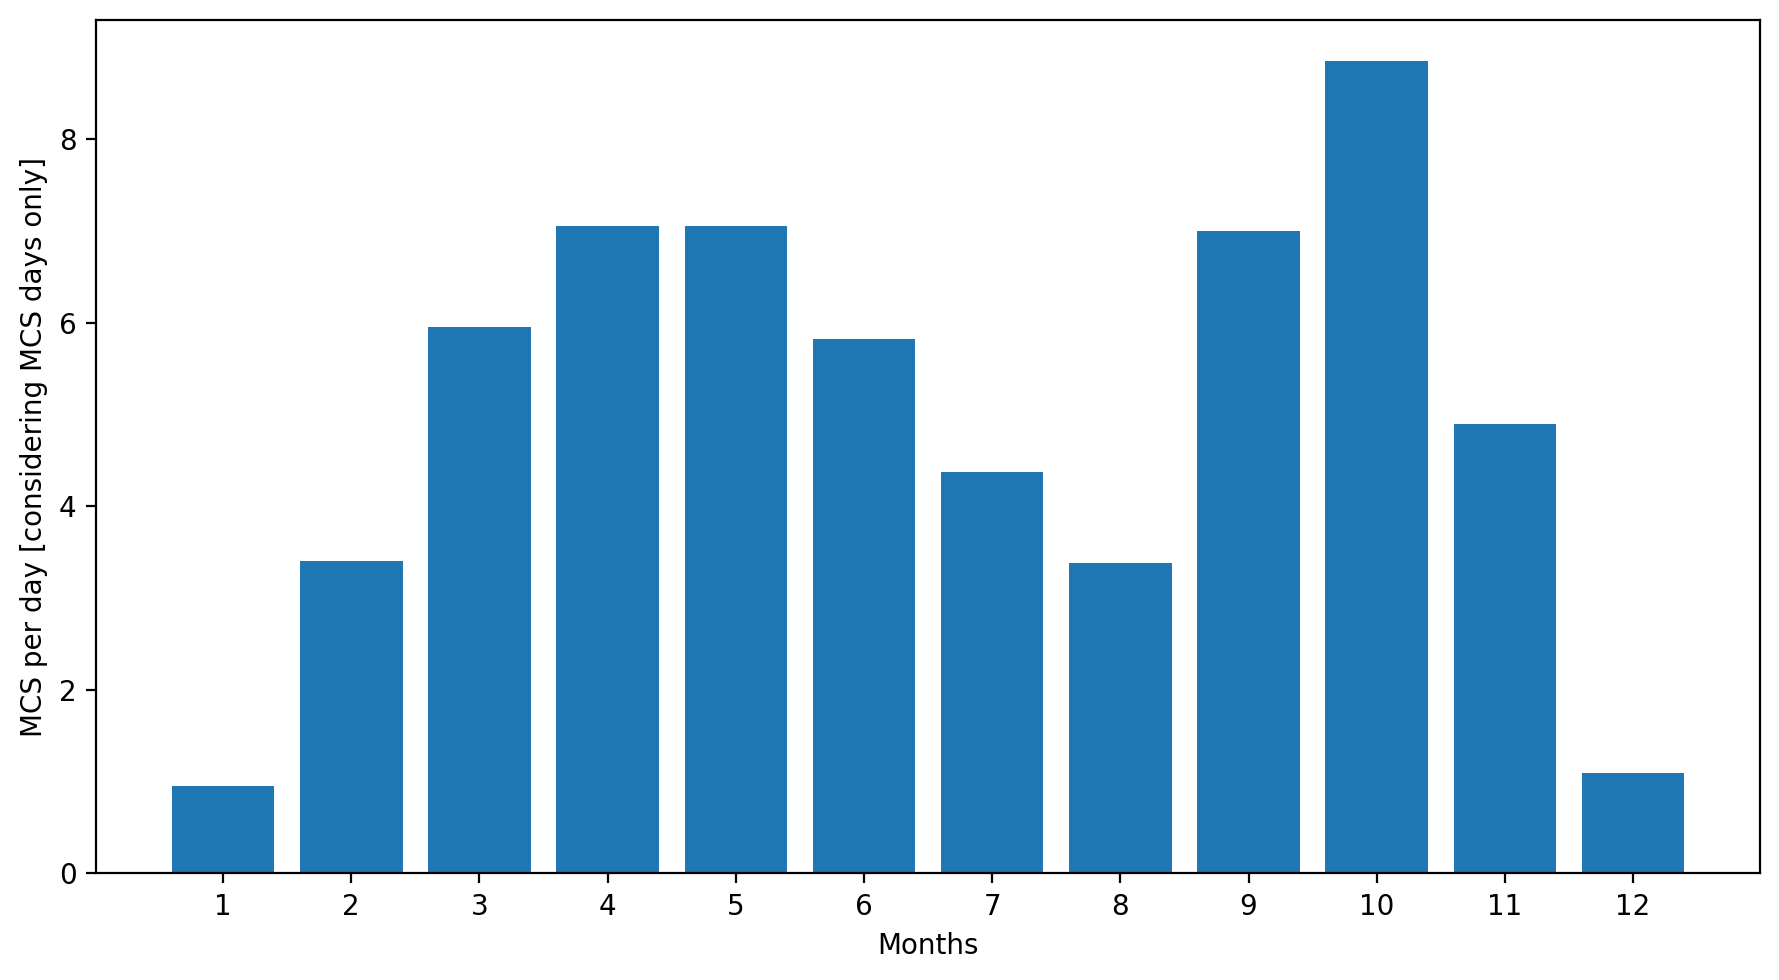

In [20]:
f = plt.figure(figsize=(9,5), dpi=200)

toconcat = []
for node in range(1,10):
    toconcat.append(pd.read_csv(cnst.DATA + '/SOMS/saves/3x3_Nodes_fullYear/mcs_matchtable/node'+str(node)+'_MCS_matchTable_mergedNodes_5mmMCS_fullYear.csv', index_col=0, parse_dates=True))
df = pd.concat(toconcat)
    
nmonth = []
ax = f.add_subplot(1,1,1)

mdays = [31,28,31,30,31,30,31,31,30,31,30,31]
for ni in range(1,13):
    nmonth.append(np.sum(df.month==ni)/(mdays[ni-1]*np.unique(df.year).size))
    print(np.unique(df.year))
print(nmonth)
ax.bar(np.arange(1,13).astype(int), np.array(nmonth))
ax.set_ylabel('MCS per day [considering MCS days only]')
ax.set_xlabel('Months')
#ax.set_title('Node:'+ str(node)+' '+merged_nodes_str[node-1])
ax.set_xticks(np.arange(1,13).astype(int))
    
plt.tight_layout()
#f.savefig(cnst.network_data + 'figs/SOMS/nb_node_permonth_nodes_fullYear.jpg')

In [5]:
all_node_file = pkl.load(open(cnst.network_data + 'data/SOMS/saves/3x3_Nodes_fullYear/node_days.p', "rb"))

In [6]:
(all_node_file['node1']).size

1624

/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attrib

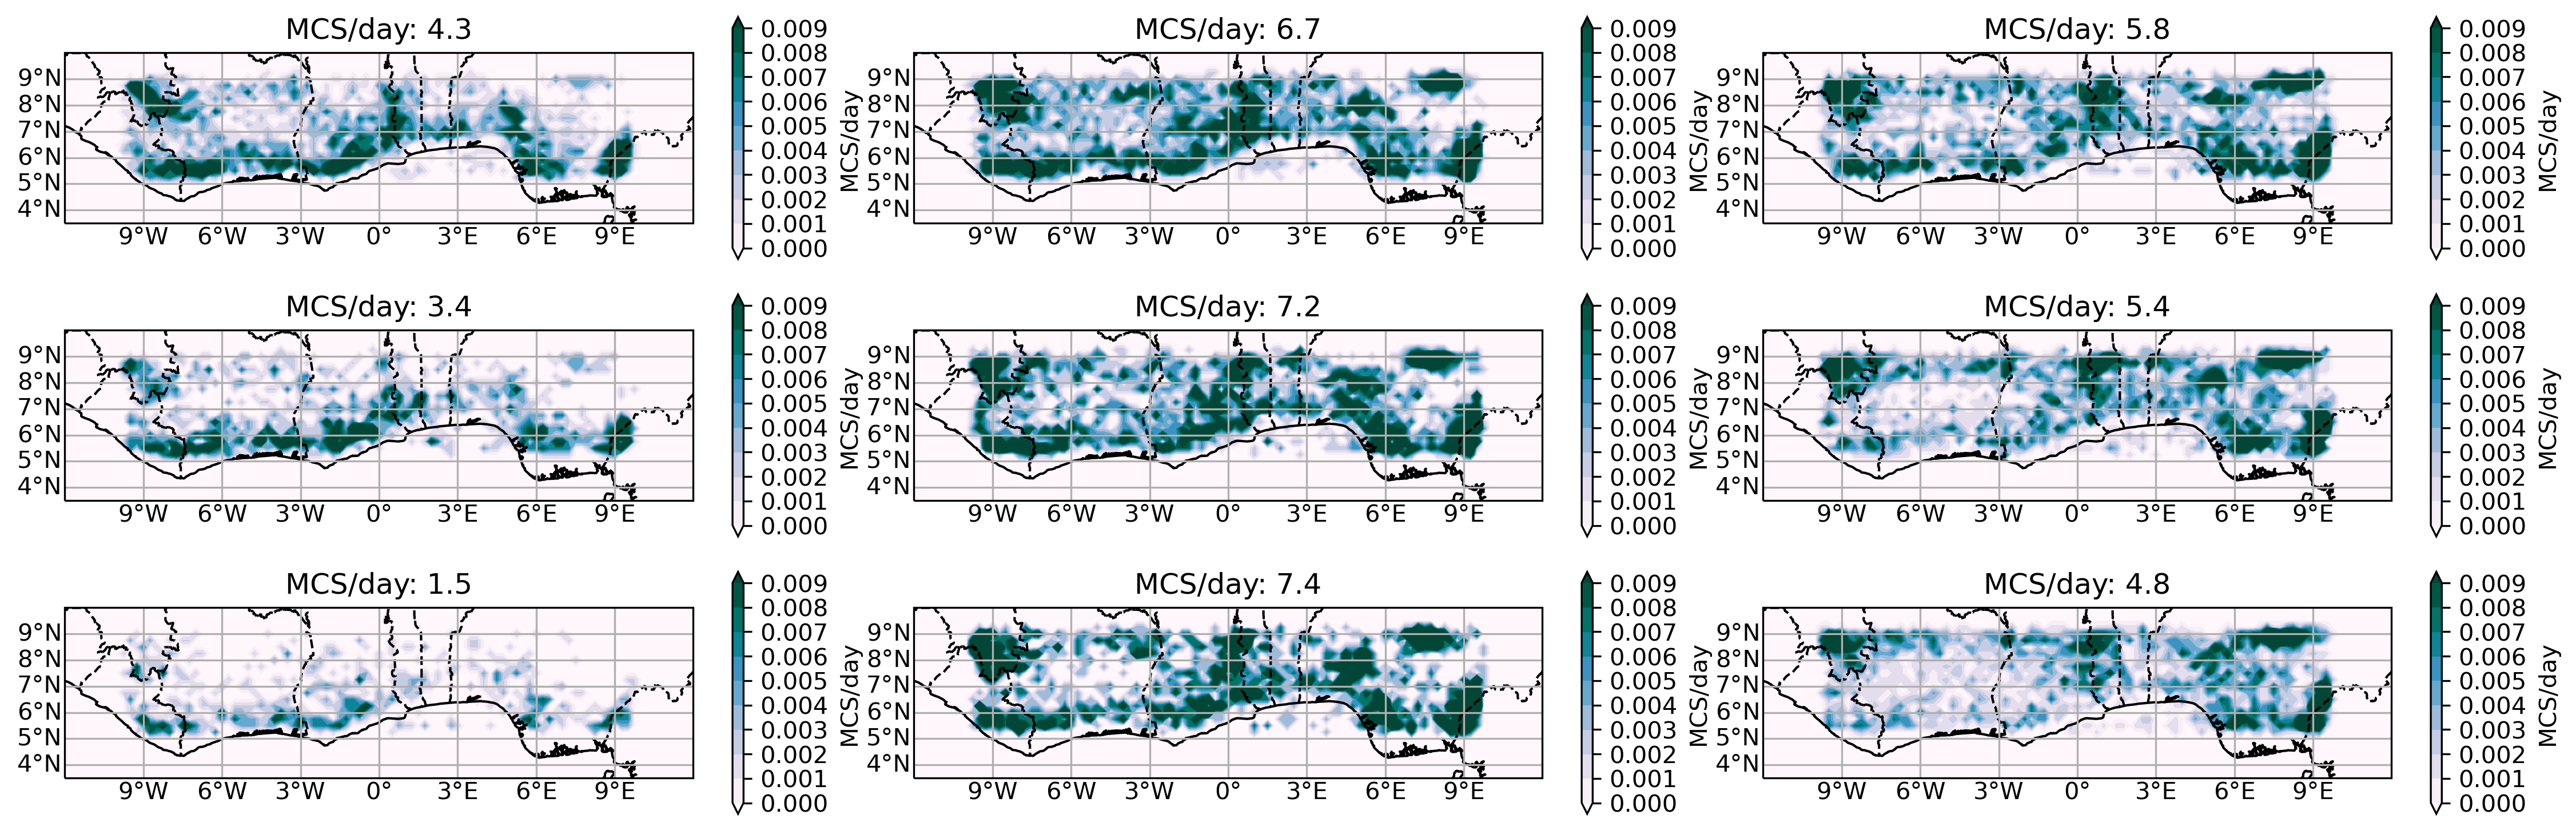

In [28]:
from utils import u_darrays as uda
f = plt.figure(figsize=(15,5), dpi=300)
mname = 'node'

for ids, m in enumerate(range(1,10)):
    
    
    pl_clim = xr.open_dataset(cnst.DATA + 'SOMS/saves/3x3_Nodes_fullYear/node1_ERA5_clim_mean_srfc.nc')
    #pl_clim = uda.flip_lat(pl_clim)
    pl_clim = pl_clim['cape'].sel(latitude=slice(3,10), longitude=slice(-12,12))
    pl_clim.values = pl_clim.values*0
    
    df = pd.read_csv(cnst.DATA + '/SOMS/saves/3x3_Nodes_fullYear/mcs_matchtable/node'+str(m)+'_MCS_matchTable_mergedNodes_5mmMCS_fullYear.csv', index_col=0, parse_dates=True)
    anf = all_node_file['node'+str(m)]
    anf = anf.where((anf.year>=2004)&(anf.year<=2015)).dropna()
    
    daycount = df.index.size/anf.size   
    #ipdb.set_trace()

    for ix, dff in df.iterrows():

        xv = dff.lon
        yv = dff.lat

        loc = pl_clim.sel(longitude=xv, latitude=yv, method='nearest')
        xm, ym = np.meshgrid(pl_clim.longitude.values, pl_clim.latitude.values)
        ipos = np.where((xm==loc.longitude.values)&(ym==loc.latitude.values))
        try:
            pl_clim.values[ipos] = pl_clim.values[ipos]+1
        except:
            ipdb.set_trace()

    plots = pl_clim.values / anf.size
    
    ax = f.add_subplot(3,3,ids+1, projection=ccrs.PlateCarree())

    plt.contourf(pl_clim.longitude, pl_clim.latitude, plots, transform=ccrs.PlateCarree(), cmap='PuBuGn', extend='both', levels=np.arange(0,0.01,0.001))
    ax.coastlines()
    # Gridlines
    xl = ax.gridlines(draw_labels=True);
    xl.xlabels_top = False
    xl.ylabels_right = False
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--');
    plt.title('MCS/day: '+str(np.round(daycount,1)))
    cbar = plt.colorbar()
    cbar.set_label('MCS/day')
   
    
    
plt.tight_layout()
#f.savefig(cnst.network_data + 'figs/LSTA/corrected_LSTA/new/wavelet_coefficients/2hOverlap/maps.png')
        
        